In [131]:
%matplotlib inline
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
import yaml, os
import cv2 as cv

from os import listdir
from os.path import isfile, join

import dac
from plotting import dict_format

In [34]:
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams.update({'font.size': 12})

<h1>Bandgap</h1>

In [61]:
fname = '../../data/testing/20220223_132341_bandgap_10800x.csv'

# Reading by rows
df = pd.read_csv(fname, header=None).set_index(0).T

In [62]:
teensy_vec = np.array(df['Teensy Internal Temp'])
temp_vec = np.array(df['TMP102'])
chamber_vec = np.array(df['Chamber'])
vbg_vec = np.array(df['Bandgap (V)'])

Bandgap Voltage Range: 0.056044006000000035


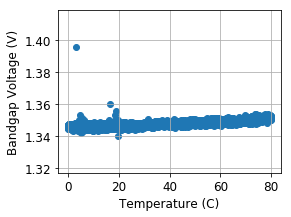

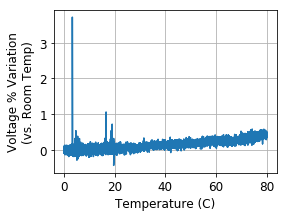

In [73]:
### Bandgap voltage plotting
# plt.scatter(teensy_vec, vbg_vec, alpha=0.5, label='Teensy Internal')
# plt.scatter(chamber_vec, vbg_vec, alpha=0.5, label='Chamber Readout')
plt.scatter(chamber_vec, vbg_vec, label='Chamber Readout')
# plt.scatter(temp_vec, vbg_vec, alpha=0.5, label='TMP102')

# plt.legend()
plt.grid(True)
plt.ylabel('Bandgap Voltage (V)');
plt.xlabel('Temperature (C)');

print(f'Bandgap Voltage Range: {max(vbg_vec)-min(vbg_vec)}')

idx_roomtemp = np.argwhere(np.diff(np.sign(chamber_vec-27))).flatten()
vout_roomtemp = vbg_vec[idx_roomtemp][0]
plt.figure()
plt.plot(chamber_vec, (vbg_vec-vout_roomtemp)/vout_roomtemp*100)
plt.xlabel('Temperature (C)')
plt.ylabel('Voltage % Variation\n(vs. Room Temp)')
plt.grid(True)

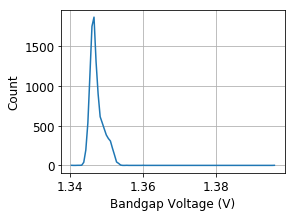

In [64]:
vbg_hist, vbg_bins_raw = np.histogram(vbg_vec, bins=100)
vbg_bins = 0.5*(vbg_bins_raw[1:] + vbg_bins_raw[:-1])
plt.plot(vbg_bins, vbg_hist)
plt.xlabel('Bandgap Voltage (V)')
plt.ylabel('Count')
plt.grid(True)

In [ ]:
### Temp Comparison Plotting
# Histogram
n_bins = 100

teensy_hist, teensy_bins_raw = np.histogram(teensy_vec, bins=n_bins)
chamber_hist, chamber_bins_raw = np.histogram(chamber_vec, bins=n_bins)
# temp_hist, temp_bins_raw = np.histogram(temp_vec, bins=n_bins)

teensy_bins = 0.5*(teensy_bins_raw[1:] + teensy_bins_raw[:-1])
chamber_bins = 0.5*(chamber_bins_raw[1:] + chamber_bins_raw[:-1])
# temp_bins = 0.5*(temp_bins_raw[1:] + temp_binw_raw[:-1])

plt.plot(teensy_bins, teensy_hist, label='Teensy Internal')
plt.plot(chamber_bins, chamber_hist, label='Chamber Readout')
# plt.plot(temp_bins, temp_hist, label='TMP102')

plt.legend()
plt.grid(True)
plt.xlabel('Temperature (C)')
plt.ylabel('Count')

In [ ]:
# Temp Differences
plt.plot(teensy_vec, label='Teensy Internal')
plt.plot(chamber_vec, label='Chamber Readout')
# plt.plot(temp_vec, label='TMP102')
plt.xlabel('Sample')
plt.ylabel('Temperature (C)')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(teensy_vec-chamber_vec, label='Teensy Internal - Chamber Readout')
plt.xlabel('Sample')
plt.ylabel('Teensy-Chamber (C)')
plt.grid(True)

In [ ]:
# 

<h1>Resistive DAC</h1>

In [48]:
plt.rcParams['figure.figsize'] = (6,2.5)
plt.rcParams.update({'font.size': 12})

<h2>INL/DNL</h2>

In [42]:
# fname = '../../data/testing/20220225_135703_dac0_1000x.csv'
fname = '../../data/testing/20220225_151239_dac1_1000x.csv'
num_iter = 1000

# Reading by rows
df = pd.read_csv(fname, header=None, names=['Code']+[f'Iteration {x}' for x in range(1,num_iter+1)])

code_data_dict = dict()
for row in df.itertuples(index=False):
    code = 255-int(row[0]) # Backwards codes, whoops...
    data = row[1:]
    code_data_dict[code] = data

In [43]:
code_max = max(code_data_dict.keys())
code_min = min(code_data_dict.keys())
print(f'Range: {np.mean(code_data_dict[code_min])}, {np.mean(code_data_dict[code_max])}')

Range: 0.274016267138, 1.1512391095119998


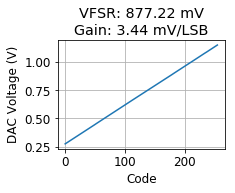

In [44]:
code_vec = code_data_dict.keys()
avg_vec = [np.mean(code_data_dict[code]) for code in code_vec]
gain = dac.calc_gain(code_data_dict)
vfsr = dac.calc_fsr(code_data_dict)

plt.plot(code_vec, avg_vec)
plt.xlabel('Code')
plt.ylabel('DAC Voltage (V)')
plt.grid(True)
plt.title(f'VFSR: {round(vfsr*1e3, 2)} mV\nGain: {round(gain*1e3, 2)} mV/LSB');
# plt.annotate(f'FSR: {vfsr}V\nGain: {gain}V/LSB', (0,0))

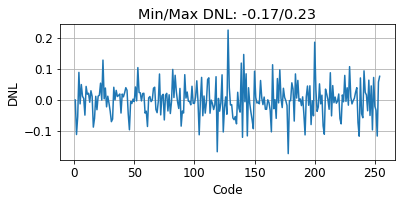

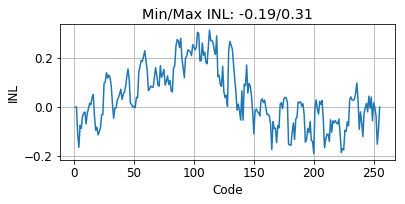

In [49]:
# Plotting DNL and INL
dnl_dict = dac.calc_dnl(code_data_dict)
code_vec, dnl_vec = dict_format(dnl_dict)
plt.plot(code_vec, dnl_vec)
plt.xlabel('Code')
plt.ylabel('DNL')
plt.grid(True)
plt.title(f'Min/Max DNL: {round(min(dnl_vec), 2)}/{round(max(dnl_vec), 2)}');
# plt.axhline(y=-1, color='r', linestyle='-')
# plt.axhline(y=1, color='r', linestyle='-')

plt.figure()
inl_dict = dac.calc_inl(code_data_dict)
code_vec, inl_vec = dict_format(inl_dict)
plt.plot(code_vec, inl_vec)
plt.xlabel('Code')
plt.ylabel('INL')
plt.grid(True)
plt.title(f'Min/Max INL: {round(min(inl_vec), 2)}/{round(max(inl_vec), 2)}');

Text(0.5,1,'Max RMS Noise: 1.17 mV')

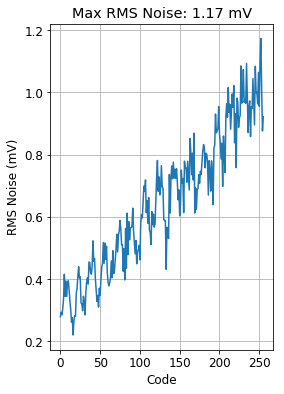

In [40]:
code_noise_dict = dac.calc_noise(code_data_dict)
code_vec, noise_vec = dict_format(code_noise_dict)
plt.plot(code_vec, [1e3*x for x in noise_vec])
plt.xlabel('Code')
plt.ylabel('RMS Noise (mV)')
plt.grid(True)
plt.title(f'Max RMS Noise: {round(max(noise_vec)*1e3, 2)} mV')

<h1>Peak Detector</h1>

In [50]:
file_in = '../../data/testing/20220303_181854_pk_200x.yaml'
with open(file_in, 'r') as f:
    data_dict = yaml.load(f, Loader=yaml.FullLoader)

In [58]:
plt.rcParams['figure.figsize'] = (4,3)
plt.rcParams.update({'font.size': 12})

In [59]:
vin_ideal_vec = data_dict['ideal']
vin_real_vec = data_dict['real']
vout_raw = data_dict['output']
vout_avg_vec = [np.mean(vout_vec) for vout_vec in vout_raw]
vout_std_vec = [np.std(vout_vec) for vout_vec in vout_raw]
vout_avg_err_vec = np.array([vout_avg_vec[i]-vin_real_vec[i] for i,_ in enumerate(vin_real_vec)])

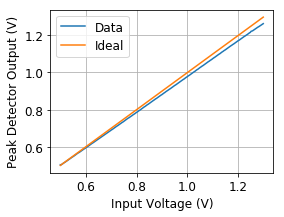

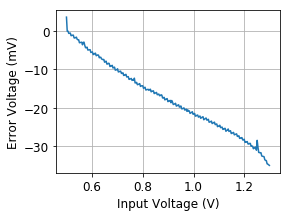

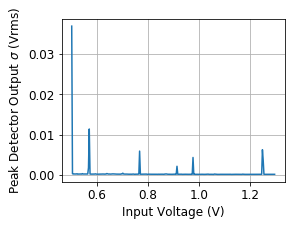

In [60]:
plt.plot(vin_real_vec, vout_avg_vec, label='Data')
plt.plot(vin_real_vec, vin_real_vec, label='Ideal')
plt.grid(True)
plt.legend()
plt.xlabel('Input Voltage (V)');
plt.ylabel('Peak Detector Output (V)');

plt.figure()
plt.plot(vin_real_vec, vout_avg_err_vec*1e3)
plt.grid(True)
plt.xlabel('Input Voltage (V)');
plt.ylabel('Error Voltage (mV)');

plt.figure()
plt.plot(vin_real_vec, vout_std_vec)
plt.grid(True)
plt.xlabel('Input Voltage (V)');
plt.ylabel('Peak Detector Output $\sigma$ (Vrms)');

In [ ]:
# Looking at conditions with worst standard deviations
idx_max_std_vec = np.argsort(vout_std_vec)[::-1]

for i in range(6):
    idx_std = idx_max_std_vec[i]
    vin = vin_real_vec[idx_std]
    vout_data = vout_raw[idx_std]
    vout_std = vout_std_vec[idx_std]
    
    plt.figure()
    plt.plot(vout_data, color='orange')
    plt.xlabel('Sample');
    plt.ylabel('Measured Output Voltage (V)');
    plt.title(f'Input Voltage: {vin} V\n$\sigma$={vout_std} Vrms');
    plt.grid(True)

<h1>Chip Image Stitching</h1>

In [21]:
start_path = '../../../presentations/20220315_figs/'
num_col_map = {0 : 5,
              1 : 4,
              2 : 6,
              3 : 8,
              4 : 5}

In [22]:
for row in num_col_map.keys():
    output_file = f'{start_path}result_r{row}.jpg'
    img_names = [f'r{row}c{col}.jpg' for col in range(num_col_map[row])]
    
    print(f'Row {row}...')
    
    img_lst = []
    height = np.inf
    for img_name in img_names:
        img = cv.imread(cv.samples.findFile(f'{start_path}{img_name}'))
        if img is None:
            print(f"Can't find {img_name}")
            continue
        img_lst.append(img)
        height = min(height, img.shape[0])

    stitcher = cv.Stitcher.create(cv.Stitcher_PANORAMA)
    status, pano = stitcher.stitch(img_lst)

    if status != cv.Stitcher_OK:
        print(f"Can't stitch: {status}")
        
    pano_height = pano.shape[0]
    pano_width = pano.shape[1]
    pano_cropped = pano[pano_height-height+75:height-75, :]
    
    cv.imwrite(output_file, pano_cropped)

Row 0...
Row 1...
Row 2...
Row 3...
Row 4...


In [32]:
img_names = [f'result_r{row}' for row in num_col_map.keys()]
img_lst = []
for img_name in img_names:
    print(img_name)
    img = cv.imread(cv.samples.findFile(f'{start_path}{img_name}.jpg'))
    if img is None:
        print(f"Can't find {img_name}")
        continue
    img_rot = cv.rotate(img, cv.ROTATE_90_COUNTERCLOCKWISE)
    img_lst.append(img_rot)
    cv.imwrite(f'{start_path}rot_{img_name}.jpg', img_rot)
    
stitcher = cv.Stitcher.create(cv.Stitcher_PANORAMA)
status, pano = stitcher.stitch(img_lst)

if status != cv.Stitcher_OK:
    print(f"Can't stitch: {status}")

cv.imwrite(f'{start_path}result.jpg', pano)

result_r0
result_r1
result_r2
result_r3
result_r4
Can't stitch: 1


error: OpenCV(4.5.5) C:\Users\lydialee\AppData\Local\Temp\pip-install-1e0b4o75\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


<h1>Small Chain ZCD Fast Testing</h1>

In [89]:
data_path = '../../data/testing'

# Get all relevant files in directory
filt = lambda f: ('zcdSmall' in f) and ('vin' in f) and ('azZeros' in f) and ('20220330' in f)
file_in_vec = [f'{data_path}/{f}' for f in listdir(data_path) if (isfile(join(data_path, f))) and filt(f)]

In [90]:
file_in_vec

['../../data/testing/20220330_114523_vin0.75V_zcdSmall_azZeros.yaml',
 '../../data/testing/20220330_114523_vin0.7V_zcdSmall_azZeros.yaml',
 '../../data/testing/20220330_114523_vin0.85V_zcdSmall_azZeros.yaml',
 '../../data/testing/20220330_114523_vin0.8V_zcdSmall_azZeros.yaml',
 '../../data/testing/20220330_114523_vin0.95V_zcdSmall_azZeros.yaml',
 '../../data/testing/20220330_114523_vin0.9V_zcdSmall_azZeros.yaml',
 '../../data/testing/20220330_114523_vin1.05V_zcdSmall_azZeros.yaml',
 '../../data/testing/20220330_114523_vin1.0V_zcdSmall_azZeros.yaml',
 '../../data/testing/20220330_114523_vin1.15V_zcdSmall_azZeros.yaml',
 '../../data/testing/20220330_114523_vin1.1V_zcdSmall_azZeros.yaml',
 '../../data/testing/20220330_114523_vin1.25V_zcdSmall_azZeros.yaml',
 '../../data/testing/20220330_114523_vin1.2V_zcdSmall_azZeros.yaml',
 '../../data/testing/20220330_114523_vin1.3V_zcdSmall_azZeros.yaml']

In [107]:
# Get mean and standard deviation of TDC readings
tdiff_avg_dict = dict()
tdiff_std_dict = dict()
vin_vec = []
tdiff_std_vec = []
tdiff_avg_vec = []
for fname in file_in_vec:
    with open(fname, 'r') as file_in:
        # Unsafe loader because of NumPy
        data_raw = yaml.load(file_in, Loader=yaml.UnsafeLoader)
        
        # Plotting raw data for sanity checking
        vin_amp = float(data_raw['config']['vin_amp'])
        tdiff_vec = data_raw['data'][2:]
#         plt.figure()
#         plt.plot([t*1e9 for t in tdiff_vec])
#         plt.xlabel('Sample')
#         plt.ylabel('Time (ns)')
#         plt.grid()
        
        # Getting stats
        tdiff_avg = np.mean(tdiff_vec)
        tdiff_std = np.std(tdiff_vec)
        tdiff_avg_dict[fname] = tdiff_avg
        tdiff_std_dict[fname] = tdiff_std
        
        vin_vec.append(vin_amp)
        tdiff_std_vec.append(tdiff_std)
        tdiff_avg_vec.append(tdiff_avg)

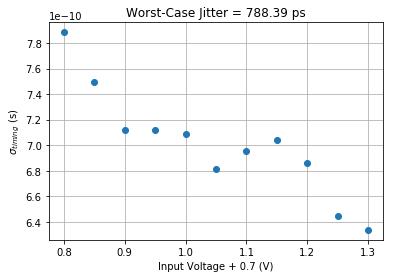

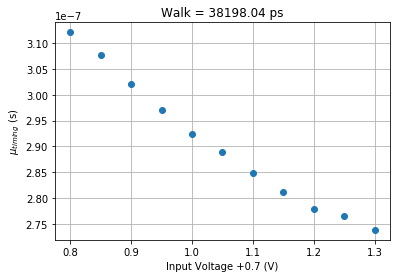

In [108]:
vin_vec = vin_vec[2:]
tdiff_std_vec = tdiff_std_vec[2:]
tdiff_avg_vec = tdiff_avg_vec[2:]

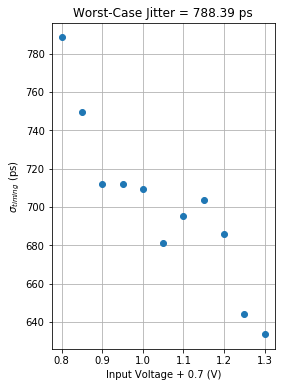

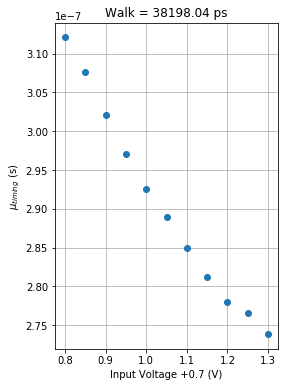

In [113]:
plt.rcParams['figure.figsize'] = (4,6)
plt.rcParams.update({'font.size': 10})

plt.plot(vin_vec, [t*1e12 for t in tdiff_std_vec], 'o')
plt.grid(True)
plt.xlabel("Input Voltage + 0.7 (V)")
plt.ylabel("$\sigma_{timing}$ (ps)")
plt.title(f'Worst-Case Jitter = {round(max(tdiff_std_vec)*1e12, 2)} ps')

plt.figure()
plt.plot(vin_vec, tdiff_avg_vec, 'o')
plt.grid(True)
plt.xlabel("Input Voltage +0.7 (V)")plt.ylabel("$\mu_{timing}$ (s)")
plt.title(f'Walk = {round((max(tdiff_avg_vec)-min(tdiff_avg_vec))*1e12, 2)} ps');

<h2>Non-Chip Jitter</h2>

In [134]:
fname = '../../data/testing/20220401_164659_1000x_boardJitter.yaml'

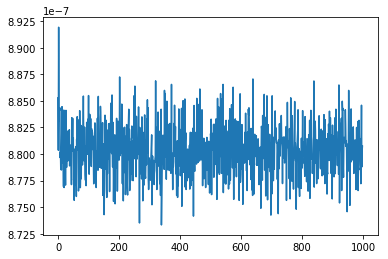

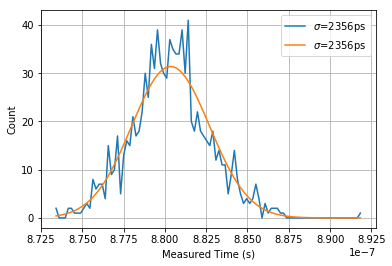

In [136]:
# Getting the raw data
with open(fname, 'r') as file_in:
    data_raw = yaml.load(file_in, Loader=yaml.UnsafeLoader)
    tdiff_vec = data_raw['data']
    
# Removing the invalid first uninitialized reading
tdiff_vec = [t for t in tdiff_vec if t > 0]

# 
plt.plot(tdiff_vec)

# Plotting the raw data
plt.figure()
tdiff_std = np.std(tdiff_vec)
tdiff_vals, tdiff_bins = np.histogram(tdiff_vec, bins=100)
tdiff_bins = 0.5*(tdiff_bins[1:]+tdiff_bins[:-1])
plt.plot(tdiff_bins, tdiff_vals, label=f'$\sigma$={round(tdiff_std*1e12)}ps')
curve_area = np.trapz(tdiff_vals, tdiff_bins)

# Fitting to normal distribution
mu, sigma = stats.norm.fit(tdiff_vec)
fit_gaussian = stats.norm.pdf(tdiff_bins, mu, sigma)
plt.plot(tdiff_bins, fit_gaussian*curve_area, label=f'$\sigma$={round(sigma*1e12)}ps')

plt.xlabel('Measured Time (s)')
plt.ylabel('Count')
plt.grid(True)
plt.legend()